<a href="https://colab.research.google.com/github/CurtCalledBurt/DS_Unit2_Build_Week/blob/master/Project_2_Day_8_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

df = pd.read_csv('/Users/curtismckendrick/Downloads/games.csv')

In [0]:
df.columns

Index(['id', 'type', 'name', 'yearpublished', 'minplayers', 'maxplayers',
       'playingtime', 'minplaytime', 'maxplaytime', 'minage', 'users_rated',
       'average_rating', 'bayes_average_rating', 'total_owners',
       'total_traders', 'total_wanters', 'total_wishers', 'total_comments',
       'total_weights', 'average_weight'],
      dtype='object')

In [0]:
24361/79463

0.30657035349785433

In [0]:
# from the glossary I have been able to deduce that:

# traders is either:
# 1. the number of people who own the game and are willing to trade it, or
# 2. the number of people who want the game through trade, not purchase

# wanters are those who want the game through trade, typically
# wishers are those who want to buy the game

# a weight on the site is an abstract measure of how complex a game is, 
# this number ranges from 1 to 5
# So,

# total_weights is either: 
# 1. the total number of people have submitted a "weight" for the game or
# 2. the total number of all the weights submitted and added up,
# and

# average_weight is most likely an average of all the measures of weight
# submitted by users. This seems most likely as this column ranges from
# 1 to 5, like the weights themselves would.


column_names = {'yearpublished': 'year_published', 'minplayers': 'min_players',
               'maxplayers': 'max_players','playingtime': 'playtime',
                'minplaytime': 'min_playtime', 'maxplaytime': 'max_playtime', 
                'minage': 'min_age'}
df = df.rename(columns=column_names)

df = df.drop_duplicates()
df_old = df.copy()
df = df[df['users_rated'] > 0]

In [0]:
# feature selection

# We try predicting 'average_rating' and see what happens with that.
target = 'average_rating'

# Obviously we wouldn't know the bayes_average_rating if we knew the average rating, 
# so we remove that from the features. 

things_we_cannot_know = ['bayes_average_rating']

things_we_do_not_need = ['name', 'type', 'id']

# turns out max_playtime and playtime are the same column in all 
# entrees except for three of them, so we'll drop playtime
redundant = ['playtime']

all_in_all = things_we_cannot_know + things_we_do_not_need + redundant


features = df.columns.drop([target] + all_in_all)
X = df[features]
y = df[target]


# We'll make a few things

# Okay, I still don't get this whole SetWithoutCopy Error thing,
# but it looks like after making new columns of X with binary operations you should 
# overwrite a copy of X with the new column and then make a new copy.
# This is the only line of code of all the feature making lines that requires this.
X=X.copy()
# X['min_age_15_or_higher'] = X['min_age'] >= 15
X=X.copy()

# Even after dropping the 0 ratings columns this feature engineering didn't do much.
# Too bad.

# X['total_interaction'] = X['total_owners'] + X['users_rated'] + X['total_traders'] + X['total_wanters'] + X['total_wishers'] + X['total_comments']
# X['total_owners_plus_raters'] = X['total_owners'] + X['users_rated']
# X['total_pos_interaction'] = X['total_owners'] + X['users_rated'] + X['total_comments']
# X['total_neg_interaction'] = X['total_traders'] + X['total_comments']
# X['hype'] = X['total_wanters'] + X['total_wishers'] + X['users_rated']
# X['mean_playtime'] = (X['min_playtime'] + X['max_playtime']) / 2
# X['new_game'] = X['year_published'] > 2010


# # normalized_df=(df-df.mean())/df.std()

# X['users_rated'] = (X['users_rated'] - X['users_rated'].mean()) / X['users_rated'].std()

In [0]:
# train/test/val split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2019)

In [0]:
# train/test/val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=2019)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((30994, 14), (30994,), (13776, 14), (13776,), (10332, 14), (10332,))

In [0]:
# quick and dirty baseline regressor
# note it returns a list the same size as the input

def baseline_Regressor(true, target):
  from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

  # making a list of the same size as 'target' 
  # with the mean of the target as the only possible entree
  mean_target = target.mean()
  pred_baseline = [mean_target] * len(true)
  
  #calculating baseline error and score
  mae = mean_absolute_error(true, pred_baseline)
  mse = mean_squared_error(true, pred_baseline)
  rmse = np.sqrt(mean_squared_error(true, pred_baseline))
  r2 = r2_score(true, pred_baseline)
  
  # printing the errors and scores
  return pred_baseline, mae, mse, rmse, r2

In [0]:
# get a list of baseline predictions
y_pred_base, mae_base, mse_base, rmse_base, r2_base = baseline_Regressor(y_val, y_train)

print("Baseline MAE: ", mae_base)
print("Baseline MSE: ", mse_base)
print("Baseline RMSE: ", rmse_base)
print("Baseline R2 Score: ", r2_base)

Baseline MAE:  1.2361119756518884
Baseline MSE:  2.5345559673252773
Baseline RMSE:  1.5920288839481769
Baseline R2 Score:  -3.1208485159028854e-05


In [0]:
# Remember that eli5 doesn't play well with pipelines, so you need to make your
# model outside of a pipeline.
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# we make our encoder and imputer in a pipeline
processor = make_pipeline(
    SimpleImputer(strategy='median')
)

# we fit the processor onto the data
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

# we make our model outside the pipeline
pipeline = RandomForestRegressor(
        n_estimators=150,
        max_depth=15,
        min_samples_leaf=20,
        random_state=2019,
        n_jobs=-1
)

# and fit our model to our processed data
pipeline.fit(X_train_processed, y_train);
# y_pred_proba = pipeline.predict(X_val_processed)

In [0]:
# # Random forest model

# # more robust modelling
# # we'll start with a random forest before making our way to xgboost
# from sklearn.pipeline import make_pipeline
# from sklearn.impute import SimpleImputer
# import category_encoders as ce
# from sklearn.ensemble import RandomForestRegressor


# pipeline = make_pipeline(
#     ce.OneHotEncoder(),
#     SimpleImputer(strategy='median'),
#     RandomForestRegressor(n_estimators=150, random_state=2019, n_jobs=-1)
# )
# # Fit the model
# pipeline.fit(X_train, y_train);

In [0]:
# RandomForest error

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def prediction_and_error(X_train_processed, y_train, pipeline, train_test_or_val):
    kind = train_test_or_val

    #make a prediction on the train set
    y_pred = pipeline.predict(X_train_processed)

    # MAE of train set
    mae = mean_absolute_error(y_train, y_pred)
    print(kind + ' MAE: ', mae)
    
    # MSE of train set
    rmse = mean_squared_error(y_train, y_pred)
    print(kind + ' MSE: ', rmse)
    
    # RMSE of train set
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    print(kind + ' RMSE: ', rmse)

    # R2 score of train set
    r2 = r2_score(y_train, y_pred)
    print(kind + ' R^2 Score: ', r2)
    
    return y_pred

In [0]:
y_pred = prediction_and_error(X_train_processed, y_train, pipeline, 'Train')

Train MAE:  0.812787487935968
Train MSE:  1.2895384916984387
Train RMSE:  1.1355784832843738
Train R^2 Score:  0.4838003737793096


In [0]:
y_pred = prediction_and_error(X_val_processed, y_val, pipeline, 'Val')
# Baseline on Val set
# Baseline MAE:  1.2361119756518884
# Baseline MSE:  2.5345559673252773
# Baseline RMSE:  1.5920288839481769
# Baseline R2 Score:  -3.1208485159028854e-05

Val MAE:  0.9005604799245981
Val MSE:  1.5812322210706697
Val RMSE:  1.2574705646935318
Val R^2 Score:  0.3761110074828199


In [0]:
import eli5
from eli5.sklearn import PermutationImportance

# See how defining an eli5 permuter takes a model but no data? that's
# why your data encoders could be used in a pipeline, but your model couldn't;
# the model needs to get passed in at definition. The data does not. 
permuter = PermutationImportance(
    pipeline,
    scoring='neg_mean_absolute_error',
    n_iter=5,
#     random_state=2019
)

# Now the data gets passed in.
permuter.fit(X_val_processed, y_val);

In [0]:
# Permutation Table

feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.1489 ± 0.0067,year_published
0.1452 ± 0.0080,total_wishers
0.1016 ± 0.0056,average_weight
0.0705 ± 0.0012,total_wanters
0.0530 ± 0.0034,total_traders
0.0291 ± 0.0025,total_owners
0.0142 ± 0.0013,min_age
0.0132 ± 0.0012,max_players
0.0107 ± 0.0015,max_playtime
0.0093 ± 0.0012,total_comments


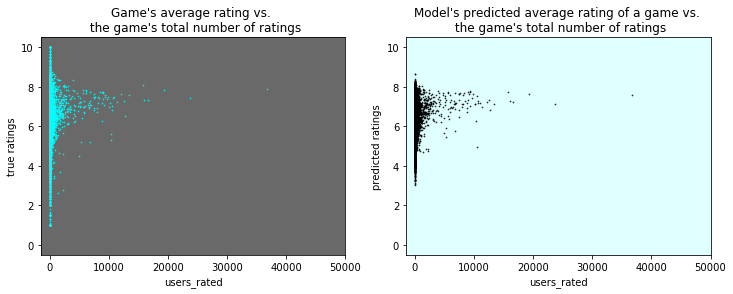

In [0]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 4))
ax1.set_facecolor('dimgray')
ax2.set_facecolor('lightcyan')

# Scatter Plot of the true average rating vs users_rated in val set
sns.regplot(X_val['users_rated'], y_val, 
            fit_reg = False, 
            scatter_kws={'color': 'cyan', 
                         's': .5}, 
            ax=ax1);

# Scatter Plot of the Predicted average rating vs users_rated in val set
sns.regplot(X_val['users_rated'], y_pred, 
            fit_reg = False, 
            scatter_kws={'color':'black', 
                         's': .5}, 
            ax=ax2);

ax1.set(title = "Game's average rating vs. \n the game's total number of ratings",
        ylabel='true ratings', 
        xlim=(-1_500, 50_000),
        ylim=(-0.5, 10.5)
       )
ax2.set(title="Model's predicted average rating of a game vs. \n the game's total number of ratings",
        ylabel='predicted ratings',
        xlim=(-1_500, 50_000),
        ylim=(-0.5, 10.5)
       )
plt.show()

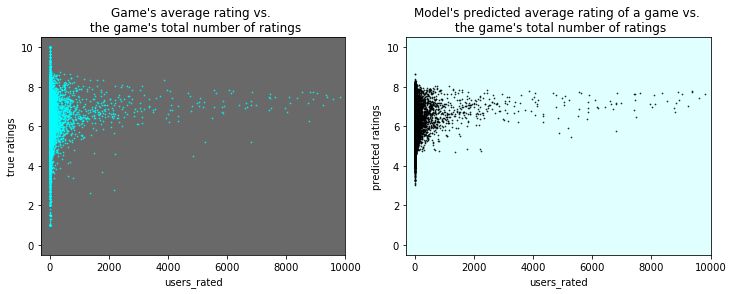

In [0]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 4))
ax1.set_facecolor('dimgray')
ax2.set_facecolor('lightcyan')

# Zoom in on True val vs users
sns.regplot(X_val['users_rated'], y_val, 
            fit_reg = False, 
            scatter_kws={'color': 'cyan', 
                         's': .5}, 
            ax=ax1);

# Zoom in on Pred val vs users
sns.regplot(X_val['users_rated'], y_pred, 
            fit_reg = False, 
            scatter_kws={'color': 'black',
                         's': .5}, 
            ax=ax2);

ax1.set(title = "Game's average rating vs. \n the game's total number of ratings",
        ylabel='true ratings', 
        xlim=(-300, 10_000),
        ylim=(-0.5, 10.5)
       )
ax2.set(title="Model's predicted average rating of a game vs. \n the game's total number of ratings",
        ylabel='predicted ratings',
        xlim=(-300, 10_000),
        ylim=(-0.5, 10.5)
       )
plt.show()

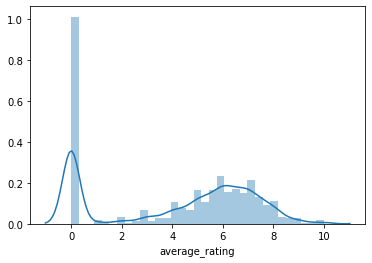

In [0]:
# histogram of average ratings

sns.distplot(df_old['average_rating']);

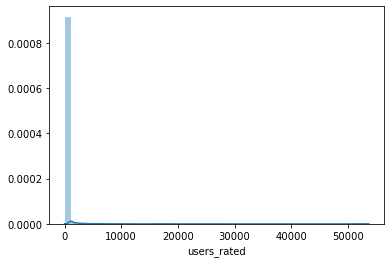

In [0]:
# histogram of number of ratings

sns.distplot(df_old['users_rated']);

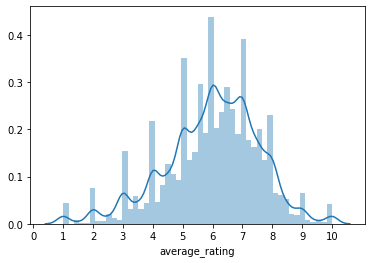

In [0]:
# average ratings excluding zeroes

fig, ax = plt.subplots()

sns.distplot(y_train, ax=ax)
ax.set(xticks=range(0,11,1))
plt.show()

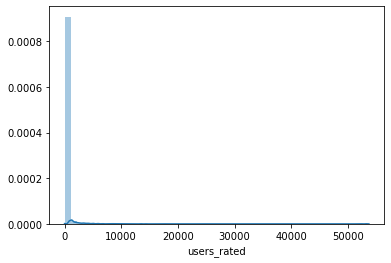

In [0]:
# number of ratings excluding zeroes

fig, ax = plt.subplots()

sns.distplot(X_train['users_rated'], ax=ax)
plt.show()

In [0]:
df_old[df_old['average_rating']== 0].shape

(24361, 20)

In [0]:
df_old[(df_old['average_rating'] >= 10) & (df_old['users_rated'] == 0)].shape

(0, 20)

In [0]:
X_train['users_rated'].value_counts()

1       6370
2       3405
3       2244
4       1615
5       1250
        ... 
3337       1
1272       1
1256       1
7371       1
1975       1
Name: users_rated, Length: 1578, dtype: int64